# How to use fuvpy

fuvpy is a collection of functions to analyse and visualize auroral images.
The package is based on xarray, and the images are stored as xarray.Dataset objects.

In [1]:
# Imports
import fuvpy as fuv
import pandas as pd
import xarray as xr
import numpy as np
import glob
import warnings
import matplotlib.pyplot as plt
from polplot import pp
warnings.filterwarnings("ignore",category =RuntimeWarning) # Turn of all the warnings when np.where contains NaNs. 

The fuvpy package includes a function to read .idl/.sav file generated with fuview3 or xvis (IMAGE and Polar software).
Images on this format are loaded as follows:

In [2]:
path = '../sample_wicfiles/'
wicfiles = glob.glob(path + '*.idl')
wic = fuv.read_idl(wicfiles,dzalim=75)
wic

<xarray.Dataset>
Dimensions:     (date: 15, row: 256, col: 256)
Coordinates:
  * date        (date) datetime64[ns] 2000-08-28T09:28:42 ... 2000-08-28T09:5...
Dimensions without coordinates: row, col
Data variables:
    img         (date, row, col) float32 684.4 722.9 689.0 ... -485.9 -485.9
    mlat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlt         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    dza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    sza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    hemisphere  (date) <U5 'north' 'north' 'north' ... 'north' 'north' 'north'
    id          <U3 'WIC'

The Dataset can conveniently be saved to a netcdf file using wic.to_nedcdf('wic.nc') and subsequently opened using xr.load_dataset('wic.nc) ro xr.open_dataset('wic.nc'). If the image data is on a different format, it must be converted to a Dataset with the same structure as wic. There are two ways to select images, by label or by index:

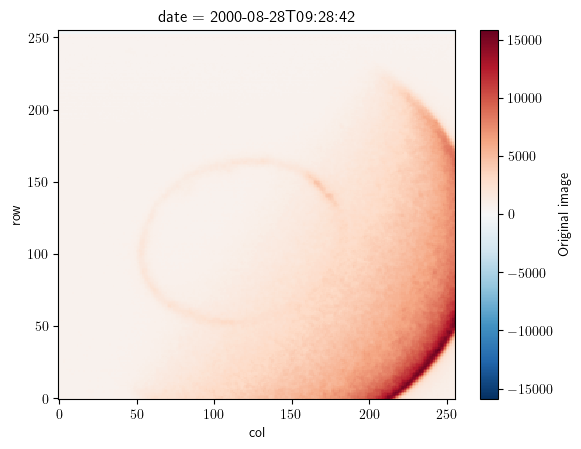

In [3]:
wic.sel(date='2000-08-28 09:28:42')['img'].plot() # Select by label

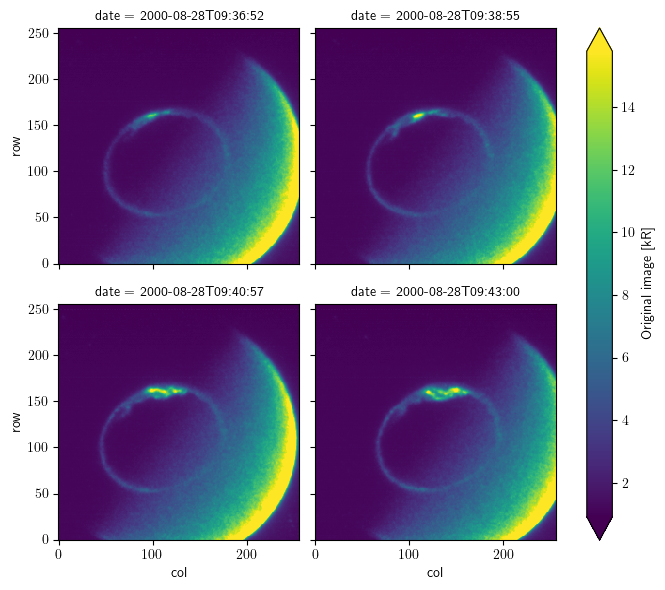

In [4]:
wic = fuv.add_rayleigh(wic,inImg='img') # Convert counts to Rayleigh
wic.isel(date=slice(4,8))['imgR'].plot(x='col', y='row', col='date', col_wrap=2,robust=True) # Select by index

In the same way we can visualize for instance the viewing anlge for these images:

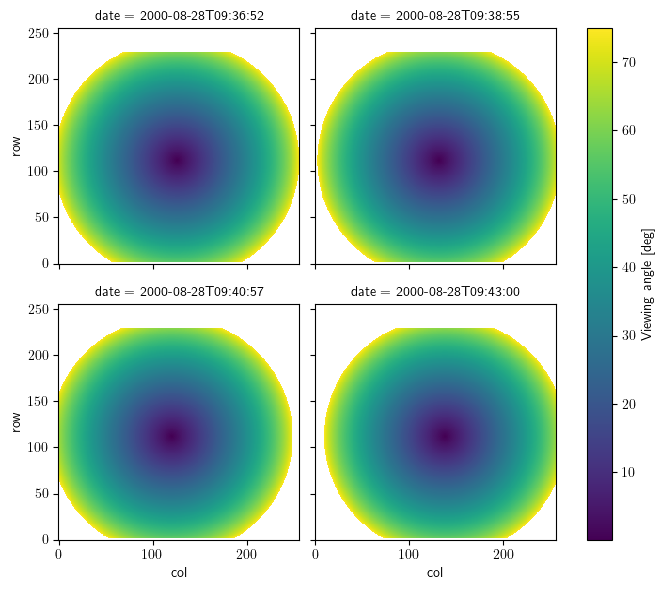

In [5]:
wic.isel(date=slice(4,8))['dza'].plot(x='col', y='row', col='date', col_wrap=2)

Note how the name and units of the variables appear automatically in the figures. They are added to each variable, and can be accessed (and assigned) using wic['nameofvariable'].attrs.

The images can be projected into polar coordinates by using polplot. fuv.plotimg is a wrapper to polplot's plotimg, and can be used as follows:

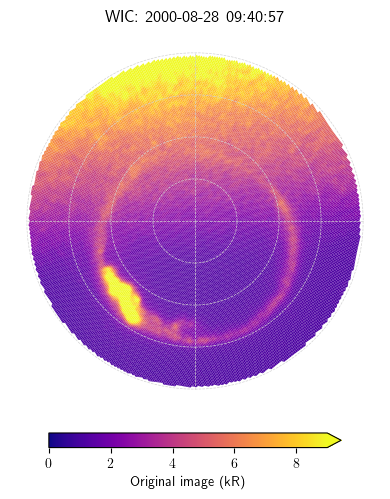

In [6]:
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.plotimg(wic.isel(date=6),'imgR',pax=pax,crange=(0,9),cmap='plasma')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{} ({})'.format(wic['imgR'].attrs['long_name'],wic['imgR'].attrs['units']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=6)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

In the above example, plotimg only does the polar projection and all other aspects of the plot must be done manually (like colorbar, title etc.). This is handy in subplots or when fine-tuning is needed. However, we sometimes just want a quick look at the images. This can be done using fuvpy.pplot, which resembles some of the functionality of xarrays 2D plot. 

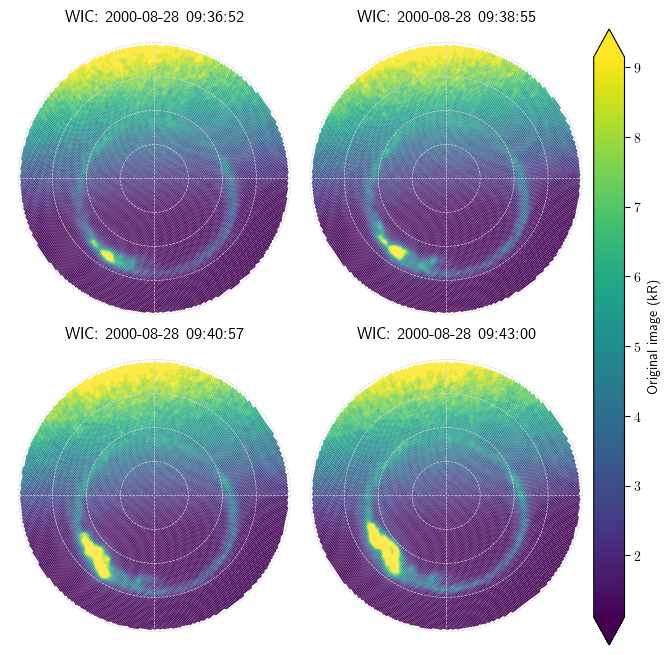

In [7]:
fuv.pplot(wic.isel(date=slice(4,8)),'imgR', col_wrap=2,robust=True,cbar_kwargs={'extend':'both'})

The images can also be plotted in an mlt-mlat projection. 

/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy/src/plotting.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel.astype(int))


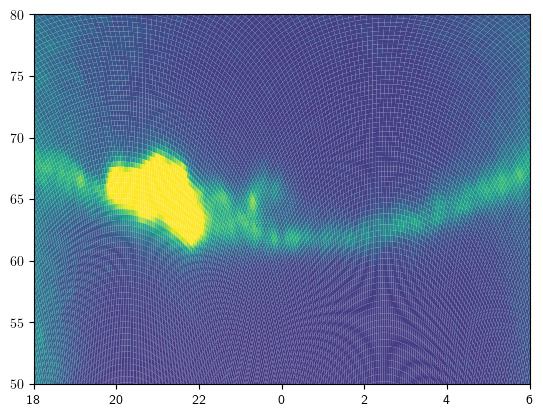

In [8]:
fuv.plot_ltlat(wic.isel(date=6),inImg='img',crange=(0,4000))

Time to remove the dayglow. A simple version of the method is described in the appendix of *Ohma et al.* (2018), but the present version is more advanced and inludes a temporal fit using B-slines. 

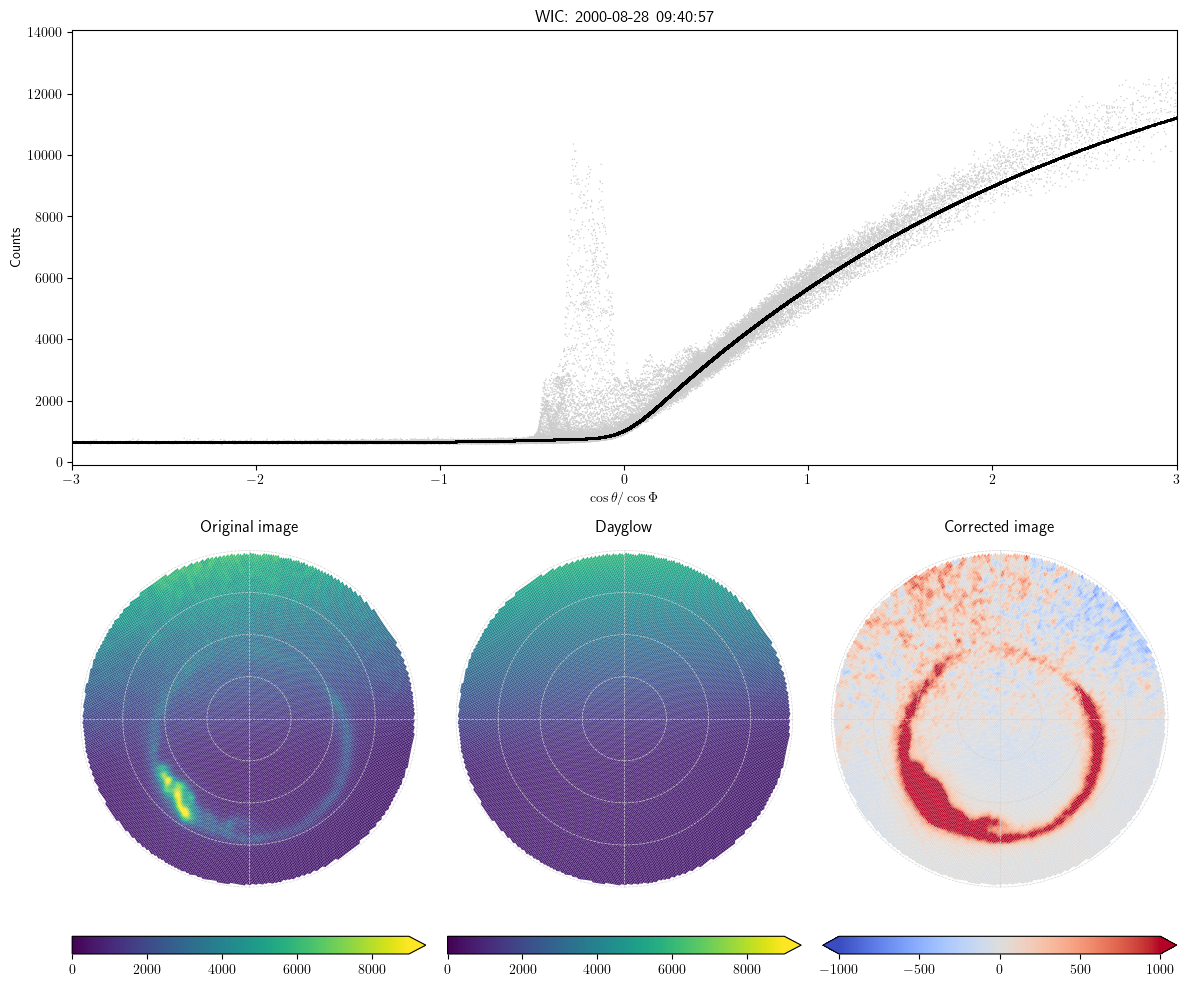

In [9]:
wic = fuv.backgroundmodel_BS(wic,tukeyVal=5,tOrder=0)
fuv.plot_backgroundmodel_BS(wic.isel(date=6))

Dayglow is subtracted, but the image is not perfect (note the asymmetry at the dayside). We model the residual background using a spherical harmonics model. 

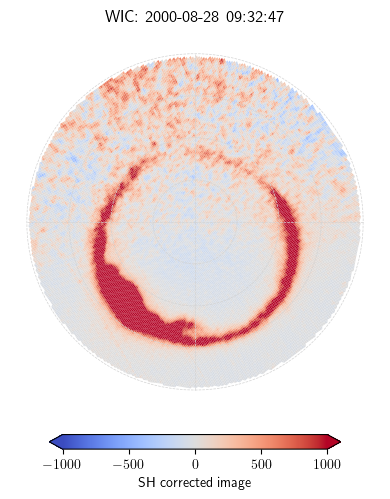

In [10]:
wic = wic.fuv.backgroundmodel_SH(4,4,dampingVal=1e-4)

# Figure
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.plotimg(wic.isel(date=6),'shimg',pax=pax,crange=(-1000,1000),cmap='coolwarm')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='both')
cbar.set_label('{}'.format(wic['shimg'].attrs['long_name']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())

plt.tight_layout()

This is staring to look great! To further examine the performance of the background model, we plot the background corrected counts (model misfit) vs solar zenith angle and the observed vs modelled counts:

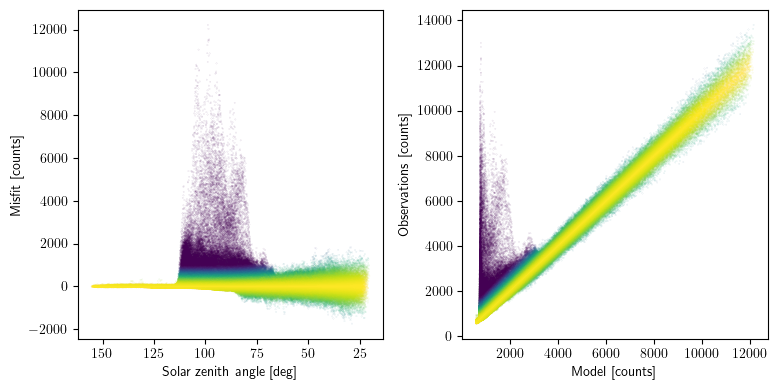

In [11]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(wic['sza'].values,wic['shimg'].values,c = wic['shweight'].values,s=0.01,alpha=0.4)
axs[0].set_xlabel('Solar zenith angle [deg]')
axs[0].set_ylabel('Misfit [counts]')
axs[0].invert_xaxis()
axs[1].scatter((wic['dgmodel'] + wic['shmodel']).values,wic['img'].values,c = wic['shweight'].values,s=0.01,alpha=0.4)
axs[1].set_xlabel('Model [counts]')
axs[1].set_ylabel('Observations [counts]')
plt.tight_layout()